# classification.cnn

> Fill in a module description here

In [ ]:
from monitosed.classification.core import *
from monitosed.data.core import *
from monitosed.models import *

from fastcore.xtras import Path
from tsai.all import *
from itertools import repeat
from IPython.display import clear_output

%load_ext autoreload
%autoreload 2

In [ ]:
users, labels = get_users_labels('../_data/Smarthy2_Behavioral.xlsx', drop_ixs=[0,2,7, 12, 13, 16])

In [ ]:
path = Path("../_data/foot1"); path.ls()

(#3) [Path('../_data/foot1/Rest'),Path('../_data/foot1/VR'),Path('../_data/foot1/VR34_VRstim_data_clean.mat')]

In [ ]:
mats_rest = load_mats(path/"Rest")
mats_vr = load_mats(path/"VR")

  0%|          | 0/14 [00:00<?, ?it/s]

Loading: VR20_Reststim_data_clean.mat
Loading: VR23_RestStim_data_clean.mat
Loading: VR26_Reststim_data_clean.mat
Loading: VR27_Reststim_data_clean.mat
Loading: VR31_Reststim_data_clean.mat
Loading: VR35_RestStim_data_clean.mat
Loading: VR38_RestStim_data_clean.mat
Loading: VR40_RestStim_data_clean.mat
Loading: VR41_RestStim_data_clean.mat
Loading: VR51_RestStim_data_clean.mat
Loading: VR52_RestStim_data_clean.mat
Loading: VR57_Reststim_data_clean.mat
Loading: VR59_Reststim_data_clean.mat
Loading: VR60_Reststim_data_clean.mat


  0%|          | 0/14 [00:00<?, ?it/s]

Loading: VR20_VRstim_data_clean.mat
Loading: VR23_VRStim_data_clean.mat
Loading: VR26_VRStim_data_clean.mat
Loading: VR27_VRstim_data_clean.mat
Loading: VR31_VRstim_data_clean.mat
Loading: VR35_VRStim_data_clean.mat
Loading: VR38_VRStim_data_clean.mat
Loading: VR40_VRstim_data_clean.mat
Loading: VR41_VRStim_data_clean.mat
Loading: VR51_VRStim_data_clean.mat
Loading: VR52_VRStim_data_clean.mat
Loading: VR57_VRstim_data_clean.mat
Loading: VR59_VRstim_data_clean.mat
Loading: VR60_VRstim_data_clean.mat


np.stack(mats_rest[-1]['data_clean']['trial'], axis=0).shape[0]+np.stack(mats_rest[-2]['data_clean']['trial'], axis=0).shape[0]

np.stack(mats_vr[-1]['data_clean']['trial'], axis=0).shape[0]+np.stack(mats_vr[-2]['data_clean']['trial'], axis=0).shape[0]

In [ ]:
n_fold = len(mats_rest)/2

In [ ]:
def run_kfold(arch, k, n_epochs=10, lr=1e-3):
    accs = []

    for i in range(int(n_fold)):
        #model = StagerNet(channels=173, embed_dim=2)
       
        print(f'Fold {i}')

        data_rest = np.concatenate([read_data(mat) for mat in np.delete(mats_rest, np.arange(2*i, 2*i+2))])
        data_vr = np.concatenate([read_data(mat) for mat in np.delete(mats_rest, np.arange(2*i, 2*i+2))])

        print(f'Len of data rest: {len(data_rest)}')
        print(f'Len of data VR: {len(data_vr)}')

        data_rest_v = np.concatenate([read_data(mat) for mat in mats_rest[2*i:2*i+2]])
        data_vr_v = np.concatenate([read_data(mat) for mat in mats_vr[2*i:2*i+2]])

        print(f'Len of validation data rest: {len(data_rest_v)}')
        print(f'Len of validation data VR: {len(data_vr_v)}')

        X = torch.cat([torch.Tensor(data_rest), torch.Tensor(data_vr)])
        X_v = torch.cat([torch.Tensor(data_rest_v), torch.Tensor(data_vr_v)])

        y = list(repeat(0., data_rest.shape[0]))+list(repeat(1., data_vr.shape[0]))
        y_v = list(repeat(0., data_rest_v.shape[0]))+list(repeat(1., data_vr_v.shape[0]))

        tfms = [None, Categorize()]

        dsets_train = TSDatasets(X, y, tfms=tfms)
        dsets_valid = TSDatasets(X_v, y_v, tfms=tfms)

        dls = TSDataLoaders.from_dsets(dsets_train,
                                   dsets_valid,
                                   bs=[64, 128],
                                   batch_tfms=[TSNormalize(), TSToGASF(cmap='summer')],
                                   shuffle=True)
        
        model = create_model(arch, dls=dls, **k)


        learn = ts_learner(dls, model, wd=1, metrics=accuracy)

        learn.fit_one_cycle(n_epochs, lr)

        accs.append(learn.recorder.values[-1][-1])
        
    return accs

In [ ]:
stgnet = StagerNet(channels=173, embed_dim=2)

In [ ]:
accs = run_kfold(n_epochs=30, lr=1e-3)

Fold 0
Len of data rest: 666
Len of data VR: 666
Len of validation data rest: 112
Len of validation data VR: 114


epoch,train_loss,valid_loss,accuracy,time
0,0.702421,0.695994,0.504425,00:04
1,0.701286,0.698188,0.504425,00:04
2,0.702113,0.700154,0.495575,00:04
3,0.702188,1.455414,0.495575,00:04
4,0.702619,0.836042,0.504425,00:04
5,0.702225,0.809931,0.486726,00:04
6,0.703992,0.713080,0.500000,00:04
7,0.702361,0.692285,0.513274,00:04
8,0.702203,0.704703,0.500000,00:04
9,0.702266,0.697316,0.504425,00:04


Fold 1
Len of data rest: 663
Len of data VR: 663
Len of validation data rest: 115
Len of validation data VR: 117


epoch,train_loss,valid_loss,accuracy,time
0,0.705362,0.695391,0.495690,00:04
1,0.703890,0.696072,0.504310,00:04
2,0.702967,0.690503,0.573276,00:04
3,0.702771,0.835396,0.495690,00:04
4,0.702550,0.830462,0.495690,00:04
5,0.702506,0.980396,0.504310,00:04
6,0.703779,0.706427,0.456897,00:04
7,0.702726,0.712891,0.495690,00:04
8,0.701285,0.681614,0.500000,00:04
9,0.700513,0.691622,0.491379,00:04


Fold 2
Len of data rest: 669
Len of data VR: 669
Len of validation data rest: 109
Len of validation data VR: 110


epoch,train_loss,valid_loss,accuracy,time
0,0.702109,0.700234,0.502283,00:04
1,0.700991,0.708766,0.502283,00:04
2,0.703673,0.705469,0.356164,00:04
3,0.704165,0.688191,0.589041,00:04
4,0.704845,0.726403,0.616438,00:04
5,0.704729,0.736976,0.424658,00:04
6,0.704563,0.684895,0.538813,00:04
7,0.704592,0.733078,0.502283,00:04
8,0.702183,0.706152,0.497717,00:04
9,0.701236,0.699713,0.506849,00:04


Fold 3
Len of data rest: 670
Len of data VR: 670
Len of validation data rest: 108
Len of validation data VR: 111


epoch,train_loss,valid_loss,accuracy,time
0,0.702449,0.693760,0.506849,00:04
1,0.701047,0.694500,0.424658,00:04
2,0.701590,0.732912,0.497717,00:04
3,0.707960,0.741218,0.506849,00:04
4,0.708563,0.746860,0.493151,00:04
5,0.705459,0.886797,0.506849,00:04
6,0.702254,0.769776,0.493151,00:04
7,0.700919,0.729812,0.493151,00:04
8,0.703937,0.686278,0.493151,00:04
9,0.702285,0.695131,0.497717,00:04


Fold 4
Len of data rest: 678
Len of data VR: 678
Len of validation data rest: 100
Len of validation data VR: 106


epoch,train_loss,valid_loss,accuracy,time
0,0.701843,0.688055,0.514563,00:04
1,0.702267,0.686159,0.519417,00:04
2,0.703704,0.697039,0.514563,00:04
3,0.702302,1.077913,0.485437,00:04
4,0.705226,1.752952,0.514563,00:04
5,0.705995,0.876490,0.446602,00:04
6,0.705504,0.686981,0.582524,00:04
7,0.705263,0.721490,0.427184,00:04
8,0.703035,0.689355,0.514563,00:04
9,0.702967,0.695125,0.441748,00:04


Fold 5
Len of data rest: 664
Len of data VR: 664
Len of validation data rest: 114
Len of validation data VR: 114


epoch,train_loss,valid_loss,accuracy,time
0,0.702997,0.697219,0.500000,00:04
1,0.701350,0.694665,0.473684,00:04
2,0.703098,0.735154,0.500000,00:04
3,0.705869,0.705668,0.473684,00:04
4,0.706337,0.751872,0.495614,00:04
5,0.707048,0.699203,0.504386,00:04
6,0.705394,0.706065,0.508772,00:04
7,0.704213,0.753733,0.500000,00:04
8,0.705419,0.695870,0.500000,00:04
9,0.703452,0.701260,0.500000,00:04


Fold 6
Len of data rest: 658
Len of data VR: 658
Len of validation data rest: 120
Len of validation data VR: 123


epoch,train_loss,valid_loss,accuracy,time
0,0.704846,0.692812,0.493827,00:04
1,0.703574,0.693361,0.485597,00:04
2,0.704332,0.692235,0.506173,00:04
3,0.706557,0.926075,0.506173,00:04
4,0.706899,0.773525,0.477366,00:04
5,0.710077,0.677513,0.547325,00:04
6,0.708971,0.712915,0.506173,00:04
7,0.706644,0.723837,0.493827,00:04
8,0.704705,0.701263,0.497942,00:04
9,0.702386,0.691429,0.506173,00:04


In [ ]:
accs

[0.5,
 0.4913793206214905,
 0.4063926935195923,
 0.5022830963134766,
 0.5922330021858215,
 0.609649121761322,
 0.4650205671787262]

In [ ]:
np.mean(accs), np.std(accs)

(0.5095654002257756, 0.06541602644789596)

In [ ]:
i=0

In [ ]:
        data_rest = np.concatenate([read_data(mat) for mat in np.delete(mats_rest, np.arange(2*i, 2*i+2))])
        data_vr = np.concatenate([read_data(mat) for mat in np.delete(mats_rest, np.arange(2*i, 2*i+2))])

        print(f'Len of data rest: {len(data_rest)}')
        print(f'Len of data VR: {len(data_vr)}')

        data_rest_v = np.concatenate([read_data(mat) for mat in mats_rest[2*i:2*i+2]])
        data_vr_v = np.concatenate([read_data(mat) for mat in mats_vr[2*i:2*i+2]])

        print(f'Len of validation data rest: {len(data_rest_v)}')
        print(f'Len of validation data VR: {len(data_vr_v)}')

        X = torch.cat([torch.Tensor(data_rest), torch.Tensor(data_vr)])
        X_v = torch.cat([torch.Tensor(data_rest_v), torch.Tensor(data_vr_v)])

        y = list(repeat(0., data_rest.shape[0]))+list(repeat(1., data_vr.shape[0]))
        y_v = list(repeat(0., data_rest_v.shape[0]))+list(repeat(1., data_vr_v.shape[0]))

        tfms = [None, Categorize()]

        dsets_train = TSDatasets(X, y, tfms=tfms)
        dsets_valid = TSDatasets(X_v, y_v, tfms=tfms)

        dls = TSDataLoaders.from_dsets(dsets_train,
                                   dsets_valid,
                                   bs=[64, 128],
                                   batch_tfms=[TSNormalize(), TSToGASF(cmap='summer')],
                                   shuffle=True)

        learn = ts_learner(dls, stgnet, wd=1, metrics=accuracy)

        learn.fit_one_cycle(10, 1e-4)

Len of data rest: 666
Len of data VR: 666
Len of validation data rest: 112
Len of validation data VR: 114


epoch,train_loss,valid_loss,accuracy,time
0,0.716926,0.713491,0.491150,00:03
1,0.720461,0.725461,0.553097,00:03
2,0.729884,0.661030,0.606195,00:03
3,0.737751,0.660194,0.637168,00:03
4,0.742483,0.709350,0.530973,00:03
5,0.736911,0.726843,0.495575,00:03
6,0.733057,0.709912,0.495575,00:03
7,0.731455,0.718297,0.486726,00:03
8,0.726464,0.729451,0.530973,00:03
9,0.725285,0.717606,0.513274,00:03


In [ ]:
learn.recorder.values[-1][-1]

0.5132743120193481

In [ ]:
stgnet = partial(StagerNet, channels=173, embed_dim=2)

In [ ]:
stgnet.__name__ = 'stgnet'

In [ ]:
archs = [(mWDN, {'levels': 4}), (FCN, {}), (ResNet, {}), (xresnet1d34, {}), (ResCNN, {}), (InceptionTime, {}), (XceptionTime, {}),
         (LSTM, {'n_layers':1, 'bidirectional': False}), (LSTM, {'n_layers':2, 'bidirectional': False}), (LSTM, {'n_layers':3, 'bidirectional': False}), 
         (LSTM, {'n_layers':1, 'bidirectional': True}), (LSTM, {'n_layers':2, 'bidirectional': True}),
         (LSTM_FCN, {}), (LSTM_FCN, {'shuffle': False})]

results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'mean accuracy', 'std accuracy', 'time'])
for i, (arch, k) in enumerate(archs):
    
    print(model.__class__.__name__)
    accs = run_kfold(arch, k, n_epochs=30)
    #learn = Learner(dls, model,  wd=0.1, metrics=accuracy)
    start = time.time()
    #learn.fit_one_cycle(30, 1e-3)
    elapsed = time.time() - start
    #vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, count_parameters(model), np.mean(accs), np.std(accs), int(elapsed)]
    results.sort_values(by='mean accuracy', ascending=False, kind='stable', ignore_index=True, inplace=True)
    clear_output()
    display(results)

,arch,hyperparams,total params,mean accuracy,std accuracy,time
0,mWDN,{'levels': 4},6469942,0.535218,0.077116,0
1,FCN,{},6469942,0.482316,0.045060,0


mWDN
Fold 0
Len of data rest: 666
Len of data VR: 666
Len of validation data rest: 112
Len of validation data VR: 114


epoch,train_loss,valid_loss,accuracy,time
0,0.707200,0.701268,0.402655,00:02
1,0.703355,0.745684,0.504425,00:02
2,0.703672,0.669767,0.495575,00:02
3,0.703532,0.709207,0.495575,00:02
4,0.704467,0.676107,0.495575,00:02
5,0.707008,0.752433,0.500000,00:02
6,0.706082,0.704095,0.495575,00:02
7,0.704355,0.684261,0.495575,00:02
8,0.701501,0.686508,0.495575,00:02
9,0.700122,0.686363,0.513274,00:02


Fold 1
Len of data rest: 663
Len of data VR: 663
Len of validation data rest: 115
Len of validation data VR: 117


epoch,train_loss,valid_loss,accuracy,time
0,0.701312,0.688654,0.500000,00:02
1,0.701392,0.679508,0.508621,00:02
2,0.704031,0.696105,0.500000,00:02
3,0.704855,0.689063,0.495690,00:02
4,0.705128,0.713636,0.504310,00:02
5,0.705451,0.666304,0.521552,00:02
6,0.705023,0.703801,0.495690,00:02
7,0.703736,0.683261,0.849138,00:02
8,0.701125,0.699328,0.478448,00:02
9,0.699625,0.699614,0.504310,00:02


Fold 2
Len of data rest: 669
Len of data VR: 669
Len of validation data rest: 109
Len of validation data VR: 110


epoch,train_loss,valid_loss,accuracy,time
0,0.701420,0.703869,0.479452,00:02
1,0.700859,0.700426,0.433790,00:02
2,0.703134,0.725723,0.438356,00:02
3,0.703719,0.697979,0.397260,00:02
4,0.704392,0.663118,0.502283,00:02
5,0.704931,0.799299,0.479452,00:02
6,0.704164,0.691390,0.534247,00:02
7,0.702477,0.679886,0.502283,00:02
8,0.701891,0.685603,0.497717,00:02
9,0.700315,0.695544,0.502283,00:02


Fold 3
Len of data rest: 670
Len of data VR: 670
Len of validation data rest: 108
Len of validation data VR: 111


epoch,train_loss,valid_loss,accuracy,time
0,0.705132,0.678527,0.753425,00:02
1,0.702746,0.687064,0.488584,00:02
2,0.705506,0.677194,0.515982,00:02
3,0.705989,0.675951,0.666667,00:02
4,0.706232,0.763779,0.506849,00:02
5,0.705641,0.680605,0.675799,00:02
6,0.705789,0.699037,0.506849,00:02
7,0.703553,0.707507,0.506849,00:02
8,0.702434,0.693249,0.493151,00:02
9,0.700856,0.683009,0.520548,00:02


Fold 4


In [ ]:
np.mean(accs)

0.5105760480676379

In [ ]:
np.std(accs)

0.10233512648204385

In [ ]:
data_rest = np.concatenate([read_data(mat) for mat in mats_rest])
data_vr = np.concatenate([read_data(mat) for mat in mats_vr])

In [ ]:
X = torch.cat([torch.Tensor(data_rest), torch.Tensor(data_vr)])
#X_v = torch.cat([torch.Tensor(data_rest_v), torch.Tensor(data_vr_v)])

In [ ]:
y = list(repeat(0., data_rest.shape[0]))+list(repeat(1., data_vr.shape[0]))
#y_v = list(repeat(0., data_rest_v.shape[0]))+list(repeat(1., data_vr_v.shape[0]))

In [ ]:
np.stack(mats_rest[-1]['data_clean']['trial'], axis=0).shape[0]+np.stack(mats_rest[-2]['data_clean']['trial'], axis=0).shape[0]

120

In [ ]:
np.stack(mats_vr[-1]['data_clean']['trial'], axis=0).shape[0]+np.stack(mats_vr[-2]['data_clean']['trial'], axis=0).shape[0]

123

In [ ]:
train_ix = 1330

In [ ]:
train_split = np.concatenate([np.arange(0, len(data_rest)-120), np.arange(len(data_rest), len(X)-123)])
val_split = np.concatenate([np.arange(len(data_rest)-120, len(data_rest)), np.arange(len(X)-123, len(X))])
splits = (train_split, val_split)

train: 0->658 + 779->1450
valid: 659->778 + 1451->1573

In [ ]:
tfms = [None, Categorize()]

In [ ]:
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
#dsets_valid = TSDatasets(X_v, y_v, tfms=tfms)

In [ ]:
dls = TSDataLoaders.from_dsets(dsets.train,
                               dsets.valid,
                               bs=[64, 128],
                               batch_tfms=[TSNormalize(), TSToGASF(cmap='summer')],
                               shuffle=True)

In [ ]:
model = create_model(ResNet, dls=dls)
learn = Learner(dls, model,  metrics=accuracy)

SuggestedLRs(valley=0.0010000000474974513)

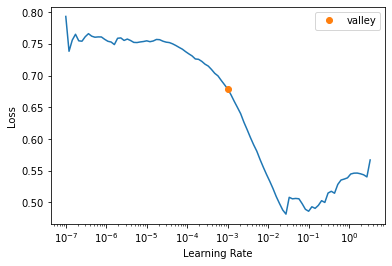

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(30, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.452104,0.970099,0.522634,00:02


KeyboardInterrupt: 

In [ ]:
learn.validate()

(#2) [1.1288049221038818,0.5555555820465088]

In [ ]:
ye_valid, y_valid = learn.get_preds()

In [ ]:
xb, yb = dls.one_batch()

In [ ]:
xb.shape

torch.Size([64, 173, 1500])

<matplotlib.image.AxesImage>

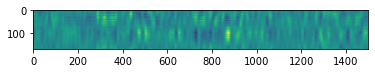

In [ ]:
plt.imshow(xb[0].cpu().numpy())

In [ ]:
from monitosed.models import *

In [ ]:
net = StagerNet(173, embed_dim=2)

In [ ]:
learn = ts_learner(dls, net, wd=1, metrics=accuracy, cbs=ShowGraph())

SuggestedLRs(valley=0.00015848931798245758)

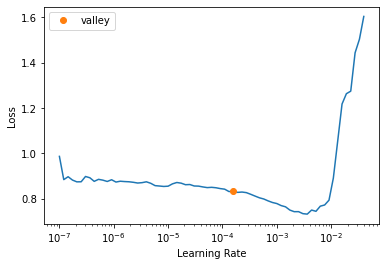

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.804757,0.750243,0.522634,00:03
1,0.778671,0.780791,0.485597,00:03
2,0.754107,0.727186,0.576132,00:03
3,0.709645,0.708419,0.596708,00:03
4,0.643204,0.745287,0.600823,00:03
5,0.572034,0.738180,0.596708,00:03
6,0.507973,0.675054,0.625514,00:03
7,0.441709,0.739956,0.617284,00:03
8,0.375905,0.793724,0.650206,00:03
9,0.318464,0.836842,0.613169,00:03


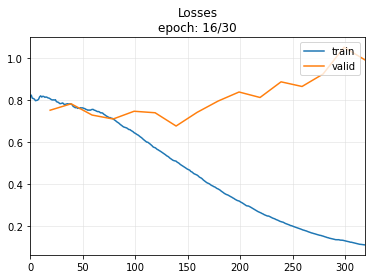

KeyboardInterrupt: 

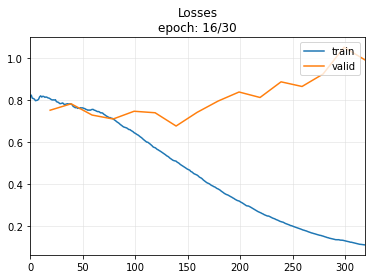

In [ ]:
learn.fit_one_cycle(30, lr_max=1e-4)

In [ ]:
archs = [(mWDN, {'levels': 4}), (FCN, {}), (ResNet, {}), (xresnet1d34, {}), (ResCNN, {}), (InceptionTime, {}), (XceptionTime, {}),
         (LSTM, {'n_layers':1, 'bidirectional': False}), (LSTM, {'n_layers':2, 'bidirectional': False}), (LSTM, {'n_layers':3, 'bidirectional': False}), 
         (LSTM, {'n_layers':1, 'bidirectional': True}), (LSTM, {'n_layers':2, 'bidirectional': True}),
         (LSTM_FCN, {}), (LSTM_FCN, {'shuffle': False})]

results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])
for i, (arch, k) in enumerate(archs):
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    learn = Learner(dls, model,  wd=0.1, metrics=accuracy)
    start = time.time()
    learn.fit_one_cycle(30, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, kind='stable', ignore_index=True, inplace=True)
    clear_output()
    display(results)

,arch,hyperparams,total params,train loss,valid loss,accuracy,time
0,mWDN,{'levels': 4},6469942,0.000196,1.233036,0.613169,139
1,InceptionTime,{},488130,0.000382,1.223705,0.588477,110
2,xresnet1d34,{},7244770,0.000140,1.676917,0.543210,56
3,LSTM,"{'n_layers': 1, 'bidirectional': True}",220402,0.003864,1.687751,0.534979,78
4,LSTM,"{'n_layers': 2, 'bidirectional': True}",462002,0.000970,2.440332,0.522634,145
5,ResNet,{},566530,0.000325,1.574891,0.506173,61
6,LSTM_FCN,{'shuffle': False},528634,0.000746,1.481025,0.506173,77
7,ResCNN,{},344323,0.000476,1.551743,0.485597,46
8,LSTM,"{'n_layers': 1, 'bidirectional': False}",110202,0.006093,1.745541,0.485597,53
9,XceptionTime,{},426740,0.186315,0.724546,0.477366,99


In [ ]:
archs = [(mWDN, {'levels': 4}), (ResNet, {}), (xresnet1d34, {}), (ResCNN, {}), (InceptionTime, {}), (XceptionTime, {}),
         (LSTM, {'n_layers':1, 'bidirectional': False})]

In [ ]:
results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])

tfms = [None, Categorize()]
bts = [[TSNormalize(), TSToPlot()], 
       [TSNormalize(), TSToMat(cmap='viridis')],
       [TSNormalize(), TSToGADF(cmap='spring')],
       [TSNormalize(), TSToGASF(cmap='summer')],
       [TSNormalize(), TSToMTF(cmap='autumn')],
       [TSNormalize(), TSToRP(cmap='winter')]]
btns = ['Plot', 'Mat', 'GADF', 'GASF', 'MTF', 'RP']
for i, (bt, btn) in enumerate(zip(bts, btns)):
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
    dls = TSDataLoaders.from_dsets(dsets.train,
                                   dsets.valid,
                                   bs=[64, 128],
                                   batch_tfms=bt,
                                   shuffle=True)
    model = StagerNet(173, embed_dim=2)
    print(model.__class__.__name__)
    learn = Learner(dls, model,  wd=1, metrics=accuracy)
    start = time.time()
    learn.fit_one_cycle(30, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [btn, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, kind='stable', ignore_index=True, inplace=True)
    clear_output()
    display(results)

,arch,hyperparams,total params,train loss,valid loss,accuracy,time
0,RP,{'shuffle': False},65944,0.000971,2.140876,0.683128,103
1,GADF,{'shuffle': False},65944,0.000311,1.834402,0.650206,103
2,Plot,{'shuffle': False},65944,0.000523,2.371059,0.646091,103
3,Mat,{'shuffle': False},65944,0.000429,2.048433,0.625514,103
4,MTF,{'shuffle': False},65944,0.000306,2.048115,0.588477,103
5,GASF,{'shuffle': False},65944,0.000439,1.873248,0.543210,103


In [ ]:
results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])

tfms = [None, Categorize()]
bts = [[TSNormalize(), TSToPlot()], 
       [TSNormalize(), TSToMat(cmap='viridis')],
       [TSNormalize(), TSToGADF(cmap='spring')],
       [TSNormalize(), TSToGASF(cmap='summer')],
       [TSNormalize(), TSToMTF(cmap='autumn')],
       [TSNormalize(), TSToRP(cmap='winter')]]
btns = ['Plot', 'Mat', 'GADF', 'GASF', 'MTF', 'RP']
for i, (bt, btn) in enumerate(zip(bts, btns)):
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
    dls = TSDataLoaders.from_dsets(dsets.train,
                                   dsets.valid,
                                   bs=[64, 128],
                                   batch_tfms=bt,
                                   shuffle=True)
    model = create_model(mWDN, dls=dls, levels=4)
    print(model.__class__.__name__)
    learn = Learner(dls, model,  wd=0.1, metrics=accuracy)
    start = time.time()
    learn.fit_one_cycle(30, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [btn, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, kind='stable', ignore_index=True, inplace=True)
    clear_output()
    display(results)

,arch,hyperparams,total params,train loss,valid loss,accuracy,time
0,GASF,{'shuffle': False},6469942,0.000174,0.928896,0.711934,140
1,Mat,{'shuffle': False},6469942,0.000182,0.960350,0.683128,140
2,MTF,{'shuffle': False},6469942,0.000293,1.008863,0.679012,140
3,Plot,{'shuffle': False},6469942,0.000244,0.959720,0.633745,140
4,RP,{'shuffle': False},6469942,0.000288,1.545471,0.567901,140
5,GADF,{'shuffle': False},6469942,0.000223,1.665993,0.534979,140


In [ ]:
xb,yb = dls.one_batch()

In [ ]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [ ]:
hook_output = Hook()
hook = learn.model.conv3.register_forward_hook(hook_output.hook_func)

In [ ]:
with torch.no_grad(): output = learn.model.eval()(xb)

In [ ]:
act = hook_output.stored[0]

In [ ]:
learn.model

StagerNet(
  (conv1): Conv2d(1, 173, kernel_size=(173, 1), stride=(1, 1))
  (conv2): Conv2d(1, 16, kernel_size=(1, 50), stride=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(1, 50), stride=(1, 1))
  (linear1): Linear(in_features=11072, out_features=2, bias=True)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
xb.shape

torch.Size([64, 173, 1500])

In [ ]:
act.shape

torch.Size([16, 173, 62])

In [ ]:
learn.model.conv3.weight.shape

torch.Size([16, 16, 1, 50])

In [ ]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [ ]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [ ]:
cls = 1
with HookBwd(learn.model.conv3) as hookg:
    with Hook(learn.model.conv3) as hook:
        output = learn.model.eval()(xb.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [ ]:
w = act[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

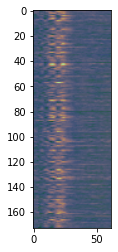

In [ ]:
_,ax = plt.subplots()
ax.imshow(xb[0].cpu().numpy())
ax.imshow(cam_map.detach().cpu(), alpha=0.6,
              interpolation='bilinear', cmap='magma');

In [ ]:
mats = load_mats(path)

  0%|          | 0/2 [00:00<?, ?it/s]

Loading: VR23_RestStim_data_clean.mat
Loading: VR20_Reststim_data_clean.mat


In [ ]:
#Optional
signal_len = 1500

In [ ]:
x = stack_trials(mats, signal_len)
y = prepare_labels(mats, labels.values)
x.shape, y.shape

(torch.Size([19376, 1, 1500]), torch.Size([19376]))

In [ ]:
read_mats = [read_data(mat) for mat in mats]
rearranged_mats = [new_rearrange(mat) for mat in read_mats]

In [ ]:
splits = create_splits(mats)

In [ ]:
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
#dls = get_ts_dls(x, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=128)
dls = get_ts_dls(x, y, splits=splits, tfms=tfms, bs=128)

In [ ]:
xb,yb = dls.one_batch(); xb,yb

(tensor([[[ 5.7587,  5.8145,  5.6909,  ..., -1.7350, -1.0917, -0.3039]],
 
         [[ 0.2592,  0.6001,  0.9024,  ...,  0.0878,  0.7782,  1.2575]],
 
         [[ 0.2450,  0.6713,  1.1601,  ...,  1.6509,  1.9004,  2.0456]],
 
         ...,
 
         [[ 0.9055,  1.9541,  2.8322,  ..., -0.5598, -0.0746,  0.3829]],
 
         [[-5.1401, -5.1290, -5.1660,  ..., -1.1601, -0.3699,  0.4581]],
 
         [[ 0.7476,  0.7960,  0.9922,  ...,  1.7452,  1.2210,  0.5381]]],
        device='cuda:0'),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.

[<matplotlib.lines.Line2D>]

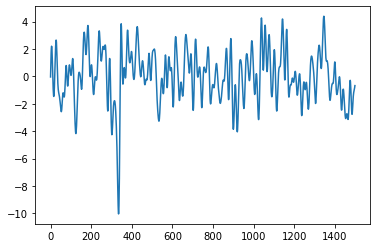

In [ ]:
plt.plot(xb[25][0].to('cpu').numpy())

SuggestedLRs(valley=0.0002754228771664202)

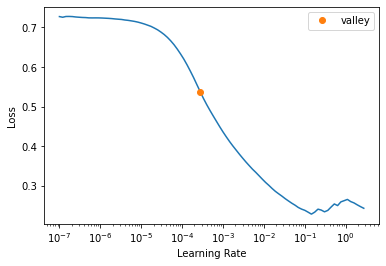

In [ ]:
learn = ts_learner(dls, InceptionTime, loss_func=CustomLoss(), metrics=[mae, rmse], wd=0.01, cbs=ShowGraph())
learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.064472,0.203931,0.310527,0.311986,00:21
1,0.023797,0.260448,0.376841,0.379547,00:21
2,0.013522,0.197043,0.302270,0.303012,00:21
3,0.007995,0.191926,0.295992,0.296411,00:21
4,0.005808,0.183075,0.284699,0.285396,00:21


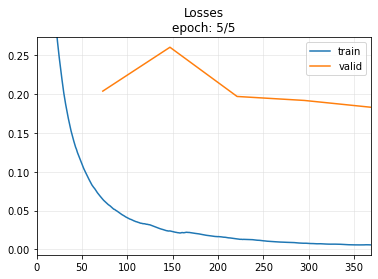

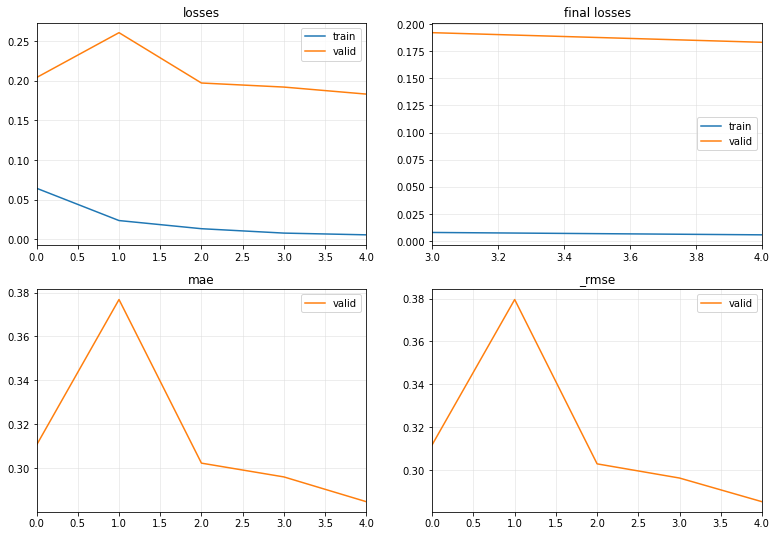

In [ ]:
learn.fit_one_cycle(5, 1e-3)

In [ ]:
model = create_model(arch, dls=dls, **k)
learn = Learner(dls, model,  metrics=accuracy)
learn.fit_one_cycle(100, 1e-3)

In [ ]:
ye_valid, y_valid = learn.get_preds()

Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:


RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 10.92 GiB total capacity; 4.54 GiB already allocated; 63.44 MiB free; 4.76 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
ye_valid

TensorBase([[1.0327],
        [1.0194],
        [1.0147],
        ...,
        [1.0063],
        [1.0032],
        [1.0098]])

In [ ]:
y_valid

torch.Size([9861])